In [1]:
!pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
# sklearn packages (for pre-processing, model-building, evaluators, cross-validators, etc.)
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder

# Imblearn packages (for over_sampling and imblearn pipelines)
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline  ## Using packages from imblearn.pipeline for making pipelines

## xgboost packages
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

!pip install tqdm
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 8.7 MB/s eta 0:00:00


In [4]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_2016.parquet")
cct_init = pd.read_parquet("/home/onyxia/work/df_cct_final.parquet")
df_index = df_cct.reset_index()
df_cct.reset_index(inplace=True, drop=True)

### One Hot Encoder

In [5]:
# For "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [6]:
# For "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [7]:
# For "Card Type":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [8]:
# For "label global":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["label_global"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [9]:
df_cct.rename(columns={0:"0", -1: "-1", 1:"1", 2:"2", 3: "3", 4:"4", 5:"5", 6:"6"}, inplace=True)


In [10]:
df_cct.columns


Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'pos_amount', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'Amex', 'Discover', 'Mastercard', 'Visa', 'Credit',
       'Debit', 'Debit (Prepaid)', '-1', '0', '1', '2', '3', '4', '5', '6'],
      dtype='object')

In [11]:
# selecting features
# dropped card, nb_weekly_declines, day_of_week, nb_daily_declines, credit, debit, amex,  discover,
# mastercard, visa
features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"Is Fraud?",
        "-1","0","1","2","3","4","5","6"]

df_selec = df_cct[features] # 21 features + clusters

X = df_selec[['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"-1","0","1","2","3","4","5","6"]]
       
y = df_selec["Is Fraud?"]

In [12]:
## Splitting the data into train and test data  (70:30)

## Create a STRATIFIED train-test (Hence, passing the argument 'stratify= y')
# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle = True, random_state = 0, stratify = y)

In [13]:
df_train = df_selec.loc[X_train.index]

In [14]:
#Create a pandas dataframe to store model results
results_df = pd.DataFrame(columns=['Data Handling Technique','Model', 'Precision','Recall','F1 score', "Our Score"])

In [55]:
#building our own score
def our_score(clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i])

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = cct_init.loc[df_index.loc[fp_rows]["index"]]
    fp_new = list(df_fp.loc[df_fp["Amount"]>=15].index)

    df_tp = cct_init.loc[df_index.loc[tp_rows]["index"]]
    tp_new = list(df_tp.loc[df_tp["Amount"]>=15].index)

    df_fn = cct_init.loc[df_index.loc[fn_rows]["index"]]
    fn_new = list(df_fn.loc[df_fn["Amount"]>=15].index)

    our_score = -15*(len(fp_new) + len(tp_new)) + cct_init.loc[tp_new].Amount.sum() - cct_init.loc[fn_rows].Amount.sum() - cct_init.loc[tp_rows].Amount.sum()

    our_score_norm = (our_score + cct_init.loc[fn_rows].Amount.sum() + cct_init.loc[tp_rows].Amount.sum())/(cct_init.loc[tp_new].Amount.sum()+cct_init.loc[fn_new].Amount.sum() - 15*(len(tp_new)+len(fn_new)))

    return our_score_norm

In [42]:
tn, fp, fn, tp = cm.ravel()
    
fp_rows = []

for i in range(len(y_pred)):
    if y_pred[i] == 1 and y.values[i] == 0:
        fp_rows.append(y.index[i])

df_fp = cct_init.loc[df_index.loc[fp_rows]["index"]]
fp_new = list(df_fp.loc[df_fp["Amount"]>=15].index)

In [56]:
#calculate retrieved or lost money
def retrieved_money(clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i])

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = cct_init.loc[df_index.loc[fp_rows]["index"]]
    fp_new = list(df_fp.loc[df_fp["Amount"]>=15].index)

    df_tp = cct_init.loc[df_index.loc[tp_rows]["index"]]
    tp_new = list(df_tp.loc[df_tp["Amount"]>=15].index)

    df_fn = cct_init.loc[df_index.loc[fn_rows]["index"]]
    fn_new = list(df_fn.loc[df_fn["Amount"]>=15].index)

    initial_loss = - cct_init.loc[fn_rows].Amount.sum() - cct_init.loc[tp_rows].Amount.sum()

    retrieved_money = -15*(len(fp_new) + len(tp_new)) + cct_init.loc[tp_new].Amount.sum() 

    max_retrieved_money = cct_init.loc[tp_new].Amount.sum()+cct_init.loc[fn_new].Amount.sum() - 15*(len(tp_new)+len(fn_new))

    return initial_loss, retrieved_money, max_retrieved_money

In [17]:
# plot confusion matrix
def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=['Non-Fraudulent','Fraudulent']
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize= 10)
    plt.xlabel('Predicted label', fontsize=10)

In [18]:
## Define a function to plot ROC_AUC curve
def plot_roc_auc_curve(fpr, tpr, roc_auc):
    print(f"ROC for test dataset {round(roc_auc*100,3)}%")  
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr,tpr,'b',label="Test ROC_AUC="+str(round(roc_auc,3)))
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.legend(loc='lower right')
    plt.show()

In [20]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=False)
kf.split(X_train, y_train)
for train_index, test_index in kf.split(X_train, y_train):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape , str("\n"))
    print("TRAIN:", train_index, "\n\nTEST:", test_index , str("\n"))

TRAIN: (4040028,) TEST: (1010007,) 

TRAIN: [1009995 1009996 1009997 ... 5050032 5050033 5050034] 

TEST: [      0       1       2 ... 1018900 1019534 1022624] 

TRAIN: (4040028,) TEST: (1010007,) 

TRAIN: [      0       1       2 ... 5050032 5050033 5050034] 

TEST: [1009995 1009996 1009997 ... 2020243 2020842 2022263] 

TRAIN: (4040028,) TEST: (1010007,) 

TRAIN: [      0       1       2 ... 5050032 5050033 5050034] 

TEST: [2020011 2020012 2020013 ... 3036840 3037069 3038746] 

TRAIN: (4040028,) TEST: (1010007,) 

TRAIN: [      0       1       2 ... 5050032 5050033 5050034] 

TEST: [3030009 3030010 3030011 ... 4042448 4042830 4043328] 

TRAIN: (4040028,) TEST: (1010007,) 

TRAIN: [      0       1       2 ... 4042448 4042830 4043328] 

TEST: [4040020 4040021 4040022 ... 5050032 5050033 5050034] 



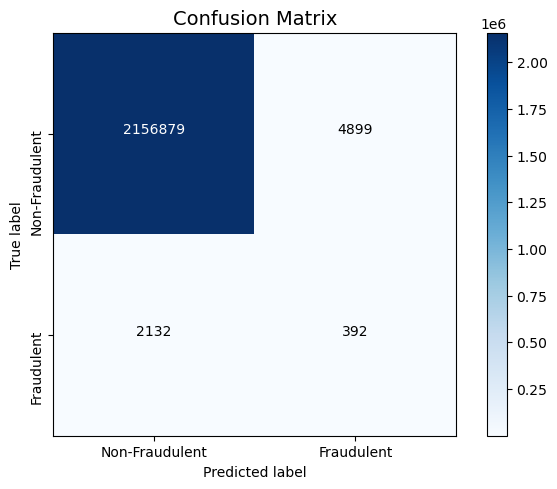

In [26]:
dt = DecisionTreeClassifier(random_state = 0, class_weight={1:16, 0:1}, min_samples_leaf = 100)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

In [57]:
our_score(dt, X_test, y_test)

0.06304184749715247

In [58]:
retrieved_money(dt, X_test, y_test)

(-140153.78, 17070.809999999998, 270785.37)

In [ ]:
print(CV_model.best_estimator_)